In [338]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as opt
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [339]:
#Hyperparameter
lr = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epoches = 3
batch_size = 32
embedding_size = 5

In [340]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.CNN1=nn.Conv2d(1, 3, 3, stride=2)
        self.CNN2=nn.Conv2d(3, 5, 3, stride=2)
        self.CNN3=nn.Conv2d(5, 10, 3, stride=2)
        self.fc1=nn.Linear(40, embedding_size)
        self.fc2=nn.Linear(40, embedding_size)
        self.fc3=nn.Linear(embedding_size + 10, 40)
        self.TCNN1=nn.ConvTranspose2d(10, 5, 3, stride=2, output_padding=1)
        self.TCNN2=nn.ConvTranspose2d(5, 3, 3, stride=2)
        self.TCNN3=nn.ConvTranspose2d(3, 1, 3, stride=2, output_padding=1)

    def forward(self, tensor, label):
        encoded=self.encode(tensor)
        mean, deviation=self.distribution(encoded)
        tensor=self.sampling(mean, deviation)

        label_tensor = torch.zeros(batch_size, 10)
        for i in range(batch_size):
            label_tensor[i][label[i]] = 1

        tensor = torch.concatenate((tensor, label_tensor), 1)
        decoded=self.decode(tensor)
        return encoded, mean, deviation, decoded

    def new_image(self, tensor):
        decoded=self.decode(tensor)
        return decoded

    def encode(self, tensor):
        tensor=self.CNN1(tensor)
        tensor=F.leaky_relu(tensor, 0.01)
        tensor=self.CNN2(tensor)
        tensor=F.leaky_relu(tensor, 0.01)
        tensor=self.CNN3(tensor)
        tensor=F.leaky_relu(tensor, 0.01)
        return tensor

    def distribution(self, tensor):
        tensor=tensor.view(-1, 40)
        mean=self.fc1(tensor)
        deviation=self.fc2(tensor)
        return mean, deviation

    def sampling(self, mean, deviation):
        tensor = torch.randn_like(mean)
        tensor = tensor.to(device)
        tensor = mean+tensor*torch.exp(deviation/2.0)
        return tensor

    def decode(self, tensor):
        tensor = self.fc3(tensor)
        tensor = tensor.view(-1, 10, 2, 2)
        tensor = self.TCNN1(tensor)
        tensor = F.leaky_relu(tensor, 0.01)
        tensor = self.TCNN2(tensor)
        tensor = F.leaky_relu(tensor, 0.01)
        tensor = self.TCNN3(tensor)
        tensor = F.tanh(tensor)
        return tensor

In [341]:
def loss_function(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE + KLD

In [342]:
#Load the dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset=datasets.MNIST("data_train", train=True, download=True, transform=transform)
testset=datasets.MNIST("data_test", train=False, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

In [343]:
criterion=nn.MSELoss()
vae=VAE()
vae=vae.to(device)
optimizer=opt.Adam(vae.parameters(), lr=lr, weight_decay=1e-4)

In [344]:
#Training
for epoch in range(epoches):
    for images, labels in trainloader:
        images = images.to(device)
        encoded, mean, deviation, decoded=vae(images, labels)

        optimizer.zero_grad()
        loss=loss_function(decoded, images, mean, deviation)
        loss.backward()
        optimizer.step()

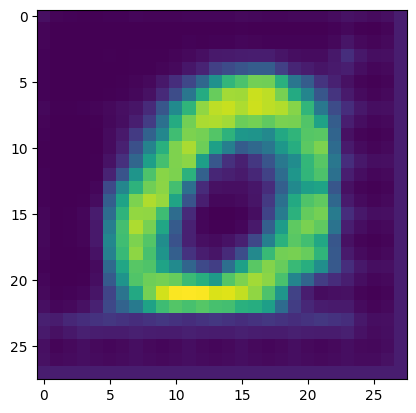

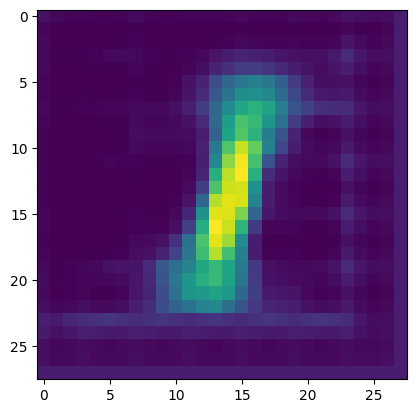

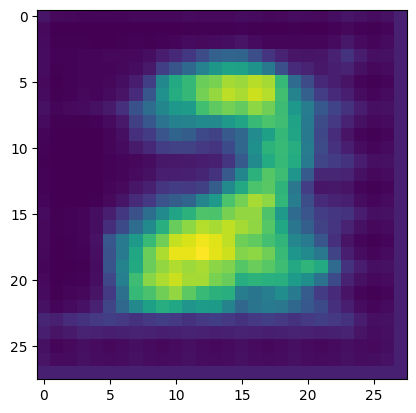

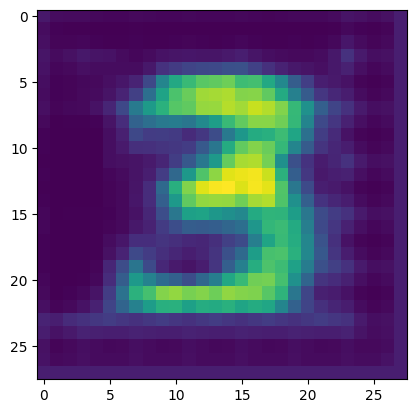

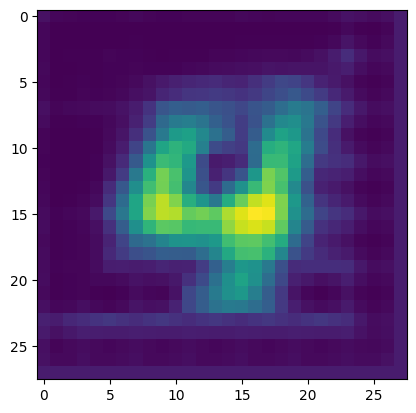

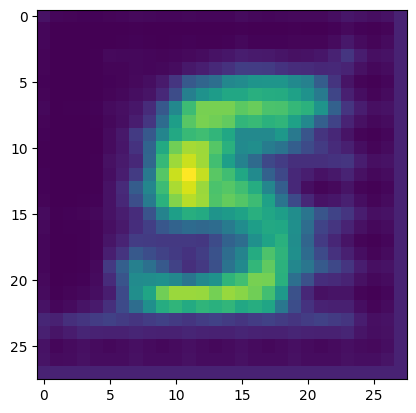

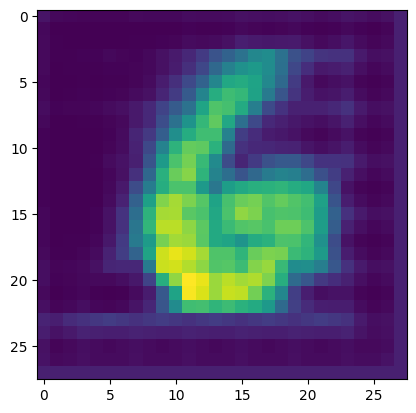

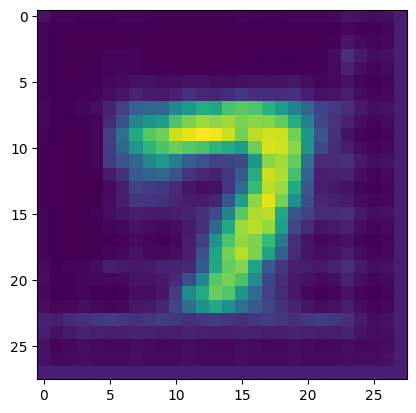

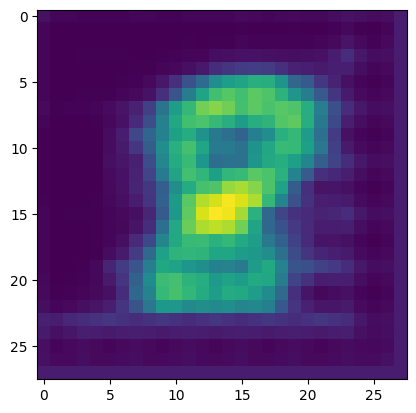

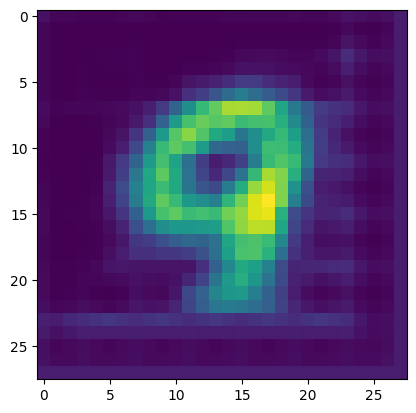

In [349]:
for number in range(10):
    noise = torch.randn(1, 5)
    label = torch.zeros(1, 10)
    label[0][number] = 1
    label = torch.concatenate((noise, label), 1)
    new_image = vae.new_image(label)
    new_image = new_image.squeeze(0).squeeze(0).detach()
    plt.imshow(new_image)
    plt.show()